# 의료영상 U-Net 용종검출

### 의료이미지 기반 진단
* Detection, Segmentation 등의 딥러닝 기술 발달이 큰 역할을 함
* U-Net: Convolutional Networks for Biomedical Image Segmentation , 2015년 발표
  - Biomedical Image Segmentation에 특화된 모델
  - 오래되고 단순한 모델 구조를 가지고 있음
  - U-Net 기반의 모델들이 용종검출(Polyp segmentation) 들의 챌린지에서 상위그룹의 성적을 내고 있음
  - 의료영상을 처리할 때의 주의사항과 특이사항을 경험


### 학습목표
* 위내시경 이미지에 용종을 표시한 데이터를 이용해 모델을 구성
* 용종을 찾는 Segmentation 모델 생성
* Data augmentation을 진행 : 의료이미지 특성상 수가 적은 데이터셋을 활용
* Encoder-Decoder Model과 U-net 모델을 구현
* U-Net이 일반 Encoder-Decoder 모델 대비 어느정도 성능향상이 되는지 확인해 본다
* U-Net에 pretrained encoder를 적용하여 성능개선을 확인

### 1. 데이터 수집 및 Visualization

#### * 위내시경 용종 데이터셋을 전처리하고 시각화하는 과정을 먼저 진행

* 라이브러리를 로딩

In [10]:
# 필요 라이브러리 로딩
from __future__ import absolute_import, division
from __future__ import print_function, unicode_literals

import os
import time
import shutil
import functools

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
from IPython.display import clear_output

import tensorflow as tf
import tensorflow_addons as tfa
print(tf.__version__)

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models

2.6.0


### 데이터 준비

In [11]:
# 데이터 준비

!mkdir -p ~/aiffel/medical
!ln -s ~/data/* ~/aiffel/medical

ln: failed to create symbolic link '/aiffel/aiffel/medical/ed_ckpt': File exists
ln: failed to create symbolic link '/aiffel/aiffel/medical/train': File exists
ln: failed to create symbolic link '/aiffel/aiffel/medical/train_labels': File exists
ln: failed to create symbolic link '/aiffel/aiffel/medical/unet_ckpt': File exists


* 데이터 세트를 학습 데이터와 테스트 데이터로 분할

In [12]:
# 데이터셋을 학습용과 테스트용으로 분리
# train, train_labels 디렉토리에 분리, 쌍을 이루는 이미지와 라벨의 파일명은 동일
# 사이킷런의 train_test_split을 이용해서 학습(train) 데이터와 테스트(test) 데이터를 분리

DATASET_PATH = os.path.join(os.getenv('HOME'), 'aiffel', 'medical')

img_dir = os.path.join(DATASET_PATH, "train")
label_dir = os.path.join(DATASET_PATH, "train_labels")

In [13]:
x_train_filenames = [os.path.join(img_dir, filename) for filename in os.listdir(img_dir)]
x_train_filenames.sort()
#x_train_filenames[:10]
y_train_filenames = [os.path.join(label_dir, filename) for filename in os.listdir(label_dir)]
y_train_filenames.sort()
#y_train_filenames[:10]

In [14]:
x_train_filenames, x_test_filenames, y_train_filenames, y_test_filenames = \
                    train_test_split(x_train_filenames, y_train_filenames, test_size=0.2)

In [15]:
num_train_examples = len(x_train_filenames)
num_test_examples = len(x_test_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples: {}".format(num_test_examples))

Number of training examples: 240
Number of test examples: 60


### 시각화(Visualization)

i: 0
img_num: 112
i: 2
img_num: 122
i: 4
img_num: 222
i: 6
img_num: 57
i: 8
img_num: 193


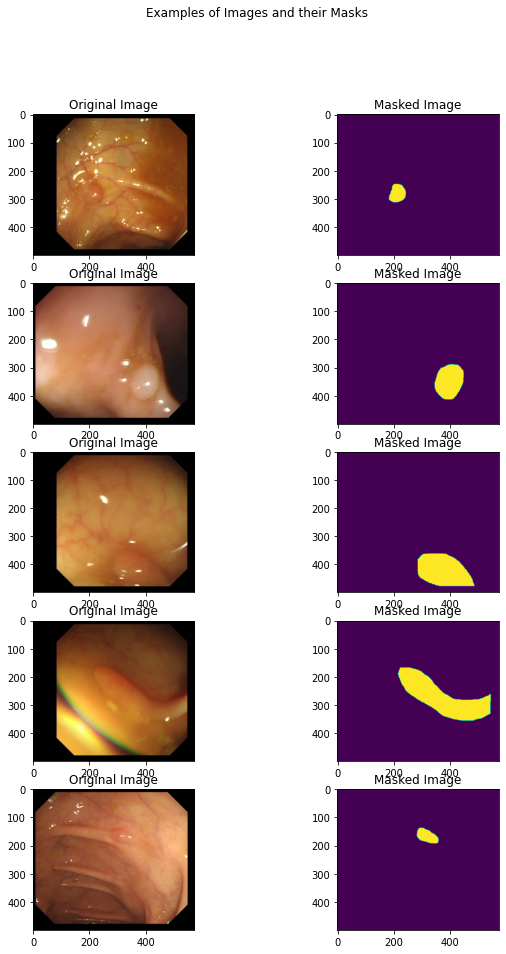

In [20]:
# 데이터 셋에서 이미지 샘플을 5개 확인

display_num = 5

r_choices = np.random.choice(num_train_examples, display_num) #훈련데이타:num_train_examples 240,5

plt.figure(figsize=(10, 15))
for i in range(0, display_num * 2, 2):
    img_num = r_choices[i // 2]
    print('i:',i)
    print('img_num:',img_num)
    x_pathname = x_train_filenames[img_num] #학습데이타-문제
    y_pathname = y_train_filenames[img_num] #학습데이타-답지

    plt.subplot(display_num, 2, i + 1)
    plt.imshow(Image.open(x_pathname))  #학습데이타-문제
    plt.title("Original Image")

    example_labels = Image.open(y_pathname) #학습데이타-답지
    label_vals = np.unique(example_labels)  

    plt.subplot(display_num, 2, i + 2)
    plt.imshow(example_labels)
    plt.title("Masked Image")
    
plt.suptitle("Examples of Images and their Masks")
plt.show()

* 클래스 값이 아니라, 입력이미지와 동일한 X-Y 사이즈를 가지고 용종 부위만 표시된 1채널짜리 이미지
* Semantic Segmentation

### 2. 데이터 파이프라인 및 전처리(Data pipeline and Preprocessing)

* 하이퍼파라메터 설정

In [22]:
# 하이퍼파라미터를 미리 셋팅

image_size = 256
img_shape = (image_size, image_size, 3)
batch_size = 8
max_epochs = 10

* tf.data를 활용한 입력 파이프라인 설계

* tf.data.Dataset을 이용해 데이터셋 구축, 배치처리 등을 진행
* 다양한 함수를 map에 적용하여 Data Augmentation을 함께 구현

#### tf.data에 대한 텐서플로우 튜토리얼에 소개된 내용을 정리
* 1.이미지와 레이블 모두 파일 이름에서 파일의 바이트를 읽습니다
   - 라벨은 실제로 각 픽셀이 용종데이터로 (1, 0)으로 주석이 달린 이미지
* 2.바이트를 이미지 형식으로 디코딩합니다
* 3._augment 함수를 통한 이미지 변환 적용 : (optional, input parameters에 따라서)
    - resize-이미지를 표준 크기로 조정
    - resize의 이유는 U-Net이 입력 크기에 의존하지 않기 때문, 이미지 크기를 조정하지 않으면 
      가변 이미지 크기를 함께 배치 할 수 없으므로 배치 크기 1을 사용
    - 성능에 영향을 줄 수 있으므로 이미지 크기를 조정
    - hue_delta-RGB 이미지의 색조를 랜덤 팩터로 조정, 이것은 실제 이미지에만 적용
       - hue_delta는[0, 0.5]간격에 있어야합니다
    - horizontal_flip-0.5 확률로 중심 축을 따라 이미지를 수평으로 뒤집기
       - 이 변환은 레이블과 실제 이미지 모두에 적용
    - width_shift_range 및height_shift_range는 이미지를 가로 또는 세로로 임의로 변환하는 범위(전체 너비 또는 높이의 일부)
       - 레이블과 실제 이미지 모두에 적용
    - rescale-이미지를 일정한 비율로 다시 조정(예 : 1/255.)
* 4.데이터를 섞고, 데이터를 반복하여 학습

#### Data augmentation의 필요성

* Data augmentation은 딥러닝을 이용한 이미지 처리분야 (classification, detection, segmentation 등) 에서 널리 쓰이는 테크닉
* 데이터 증가는 여러 무작위 변환을 통해 데이터를 증가시켜 훈련 데이터의 양을 "증가"
* 훈련 시간 동안 우리 모델은 똑같은 그림을 두 번 볼 수 없습니다. 따라서 Overfitting을 방지하고, 모델이 처음보는 데이터에 대해 더 잘 일반화되도록 도와줌

#### 각 경로명 처리(Processing each pathname)

* 이미지 데이터를 로드하는 함수를 구현
  - byte 형태로 데이터를 로드하고, bmp로 디코딩
  - 디코딩이 완료된 image를 scale과 size를 조절

In [23]:
# 경로명 처리
def _process_pathnames(fname, label_path):
    # We map this function onto each pathname pair
    img_str = tf.io.read_file(fname)
    img = tf.image.decode_bmp(img_str, channels=3)

    label_img_str = tf.io.read_file(label_path)
    label_img = tf.image.decode_bmp(label_img_str, channels=3) #byte 형태로 데이터를 로드하고, bmp로 디코딩
    label_img = tf.image.rgb_to_grayscale(label_img)

    resize = [image_size, image_size]
    img = tf.image.resize(img, resize)  #디코딩이 완료된 image size를 조절
    label_img = tf.image.resize(label_img, resize) #디코딩이 완료된 label_img 를 scale과 size를 조절

    scale = 1 / 255.
    img = tf.cast(img, dtype=tf.float32) * scale
    label_img = tf.cast(label_img, dtype=tf.float32) * scale

    return img, label_img

#### 데이터 증강 - 이미지 이동 (Data augmentation - Shifting the image)

* 로드한 이미지를 기반으로 이미지의 위치를 적절히 이동(shift)시키는 함수
* 입력이미지와 라벨의 쌍을 동일하게 shift

In [28]:
#이미지 이동
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
    # 수평 또는 수직 이동을 수행
    if width_shift_range or height_shift_range:
        if width_shift_range: #수평이동
                width_shift_range = tf.random.uniform([],
                                                  -width_shift_range * img_shape[1],
                                                  width_shift_range * img_shape[1])
        if height_shift_range: #수직이동
                height_shift_range = tf.random.uniform([],
                                                   -height_shift_range * img_shape[0],
                                                   height_shift_range * img_shape[0])
        output_img = tfa.image.translate(output_img,
                                         [width_shift_range, height_shift_range])
        label_img = tfa.image.translate(label_img,
                                        [width_shift_range, height_shift_range])
    return output_img, label_img

#### 데이터 증강 - 무작위로 이미지 뒤집기(Data augmentation - Flipping the image randomly)

* 로드한 이미지를 기반으로 이미지를 flip하는 함수, 50%의 확률로 좌우반전만 구현

In [29]:
# 무작위로 이미지 뒤집기
def flip_img(horizontal_flip, tr_img, label_img):
    if horizontal_flip: #좌우반전만
        flip_prob = tf.random.uniform([], 0.0, 1.0)
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))
    return tr_img, label_img

#### 데이터 증강 구현

* Augmentation용 함수를 이용해 Data augmentation에 사용하는 _augment() 함수를 구성
* resize, hue_delta가 적용

In [31]:
#데이터 증강 구현
def _augment(img,
             label_img,
             resize=None,  # 이미지 크기를 일부 크기로 조정, 예제)[256, 256]
             scale=1,  # 스케일 이미지, 예제) 1 / 255.
             hue_delta=0.,  # 무작위 요소로 RGB 이미지의 색조 조정
             horizontal_flip=True,  # 무작위 왼쪽 오른쪽 뒤집기
             width_shift_range=0.05,  # 이미지를 무작위로 수평으로 번역
             height_shift_range=0.05):  # 이미지를 무작위로 수직으로 번역
    if resize is not None: #resize 값이 존재시 처리
        # Resize both images
        label_img = tf.image.resize(label_img, resize)
        img = tf.image.resize(img, resize)
  
    if hue_delta:
        img = tf.image.random_hue(img, hue_delta)
  
    img, label_img = flip_img(horizontal_flip, img, label_img)
    img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
    label_img = tf.cast(label_img, dtype=tf.float32) * scale
    img = tf.cast(img, dtype=tf.float32) * scale
    return img, label_img

#### 학습 및 테스트 데이터 세트 설정

* tf.data.Dataset을 이용하여 데이터셋 배치구성, 셔플링 등을 구현
* augmentation도 함께 적용
* 단, Train dataset에서만 Data augmentation을 진행하게 설정하는 것에 주의 !!!

In [32]:
# 기준 데이터세트 가져오기
def get_baseline_dataset(filenames,
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=4,
                         batch_size=batch_size,
                         is_train=True):
    num_x = len(filenames)
    
    # 파일 이름과 라벨로 데이터 세트 만들기
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    
    # 전처리 기능을 데이터 세트의 모든 요소에 매핑하여 다음을 수행
    # 멀티스레딩의 장점
    dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)

    if is_train:# 학습을 진행할시에만 위에 augment를 진행합니다.
        #preproc_fn.keywords가 None이 아니고 preproc_fn.keywords에 '크기 조정'이 없는 경우:
        #  batch_size == 1, 일괄 처리 이미지의 크기는 동일해야 함
        dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
        dataset = dataset.shuffle(num_x * 10)

    dataset = dataset.batch(batch_size)
    return dataset

In [33]:
#학습 및 테스트 데이터 세트 설정하기
train_dataset = get_baseline_dataset(x_train_filenames, # 학습 데이터
                                     y_train_filenames) # 학습-정답 데이터
train_dataset = train_dataset.repeat()

test_dataset = get_baseline_dataset(x_test_filenames,  #테스트 데이터
                                    y_test_filenames,  #테스트-정답 데이터
                                    is_train=False)
train_dataset

<RepeatDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>

#### 학습데이터 구성 (Plot some train data)

* 학습 데이터를 확인
* data augmentation 효과가 잘 적용되었나 확인

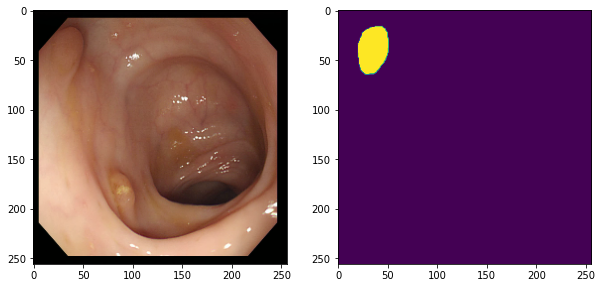

In [35]:
#학습데이터 시각화하기
for images, labels in train_dataset.take(1):
    # 그래프에서 다음 요소를 실행하면 일련의 이미지가 생성
    plt.figure(figsize=(10, 10))
    img = images[0]

    plt.subplot(1, 2, 1)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    plt.imshow(labels[0, :, :, 0])
    plt.show()

### 3. 모델 구축(Build the model)

* 두 개의 네트워크를 만들어 보고 성능을 비교
* Encoder-Decoder 스타일의 네트워크, U-Net

#### 3-1) 인코더-디코더 아키텍처(Encoder-Decoder architecture)

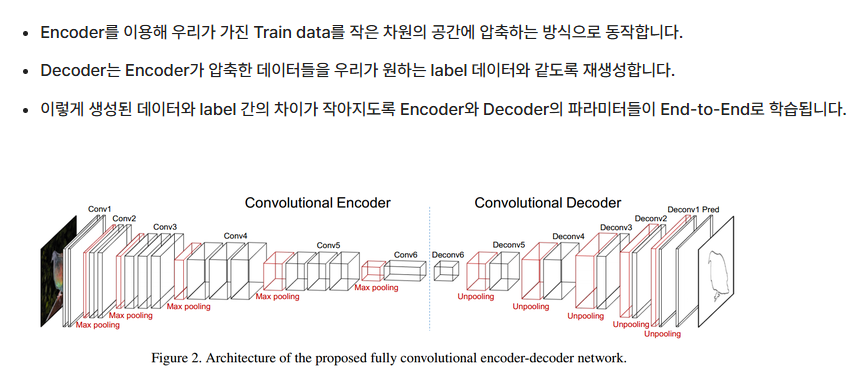

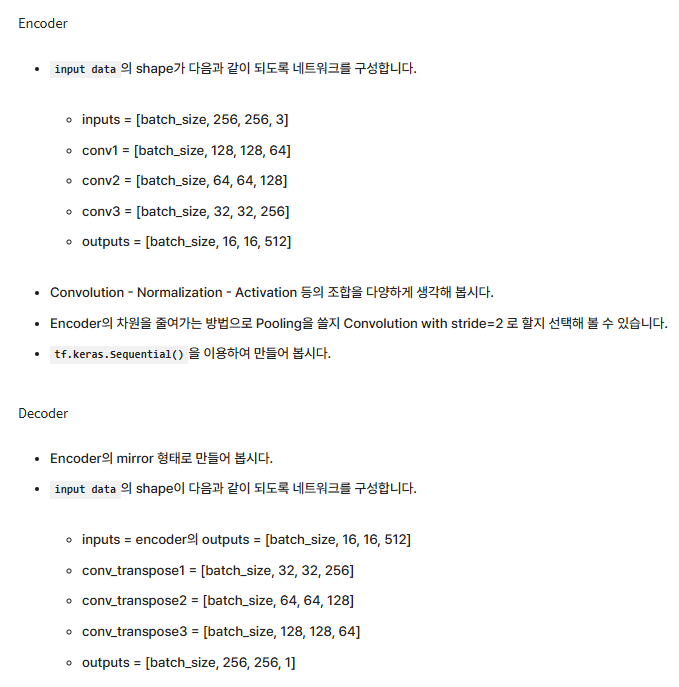

In [36]:
#------------------------------------------------------------------
# 인코더-디코더 아키텍처(Encoder-Decoder architecture)중 인코더부분 
#------------------------------------------------------------------

# inputs: [batch_size, 256, 256, 3]
encoder = tf.keras.Sequential(name='encoder')

# conv-batchnorm-activation-maxpool
encoder.add(layers.Conv2D(64, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(64, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv1: [batch_size, 128, 128, 64]

encoder.add(layers.Conv2D(128, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(128, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv2: [batch_size, 64, 64, 128]

encoder.add(layers.Conv2D(256, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(256, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv3: [batch_size, 32, 32, 256]

encoder.add(layers.Conv2D(512, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(512, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv4-outputs: [batch_size, 16, 16, 512]

In [37]:
# Encoder 제대로 만들어졌는지 확인

bottleneck = encoder(tf.random.normal([batch_size, 256, 256, 3]))
print(bottleneck.shape)   # (batch_size, 16, 16, 512) 이 나오는지 확인

(8, 16, 16, 512)


In [38]:
#------------------------------------------------------------------
# 인코더-디코더 아키텍처(Encoder-Decoder architecture)중 디코더부분 
#------------------------------------------------------------------

# inputs: [batch_size, 16, 16, 512]
decoder = tf.keras.Sequential(name='decoder')

# conv_transpose-batchnorm-activation
decoder.add(layers.Conv2DTranspose(256, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose1: [batch_size, 32, 32, 256]
decoder.add(layers.Conv2D(256, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose2: [batch_size, 64, 64, 128]
decoder.add(layers.Conv2D(128, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose3: [batch_size, 128, 128, 64]
decoder.add(layers.Conv2D(64, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv transpose4-outputs: [batch_size, 256, 256, 32]
decoder.add(layers.Conv2D(32, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(1, 1, strides=1, padding='same', activation='sigmoid'))

In [39]:
# decoder 제대로 만들어졌는지 확인

predictions = decoder(bottleneck)
print(predictions.shape)    # (batch_size, 256, 256, 1) 이 나오는지 확인

(8, 256, 256, 1)


#### 인코더-디코더 모델 만들기

In [40]:
#Encoder와 Decoder를 결합한 모델 구성
ed_model = tf.keras.Sequential()

ed_model.add(encoder) #인코더모델
ed_model.add(decoder) #디코더모델

#### 3-2) U-Net 아키텍처 (U-Net architecture)

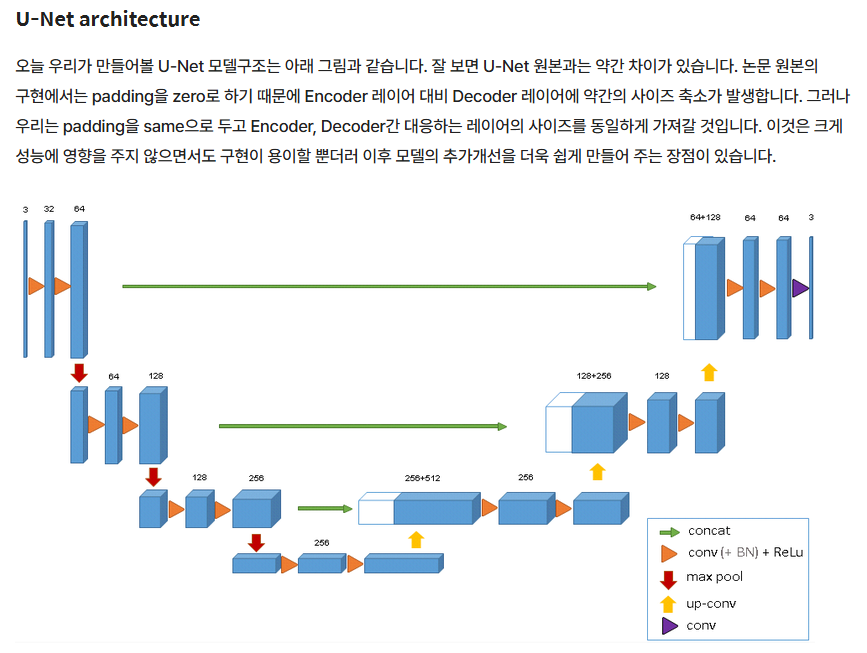

*논문 원본의 padding을 zero로 하면 사이즈 축소가 발생-> adding을 same으로 두고 Encoder, Decoder간 대응하는 레이어의 사이즈를 동일하게 처리

#### 모델 서브클래싱을 활용한 구현

* U-Net은 Encoder-Decoder 구조와는 달리 해당 레이어의 outputs이 바로 다음 레이어의 inputs이 되지 않습니다
  - Encoder-Decoder 모델처럼 tf.keras.Sequential()을 쓸 수가 없음
* Sequential 구조가 아닌 네트워크를 만들 때 쓸 수 있는 API 가 바로 tf.keras functional API 임
  - U-Net 구현을 위해 Model subclassing 방식을 사용하여, tf.keras.Model 클래스를 상속하여 구현예정

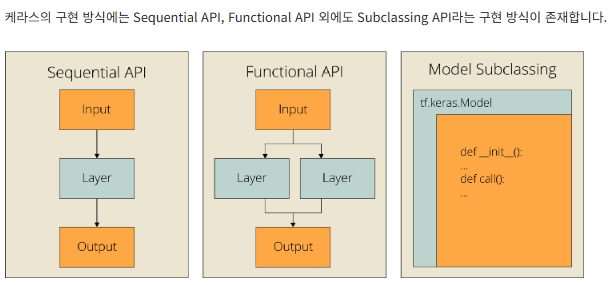

In [42]:
#
class Conv(tf.keras.Model):
    def __init__(self, num_filters, kernel_size):
        super(Conv, self).__init__()
        self.conv = layers.Conv2D(num_filters, kernel_size, padding='same')
        self.bn = layers.BatchNormalization()

    def call(self, inputs, training=True):
        x = self.conv(inputs)
        x = self.bn(x, training=training)
        x = layers.ReLU()(x)

        return x

In [43]:
#
class ConvBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters * 2, 3)

    def call(self, inputs, training=True):
        encoder = self.conv1(inputs, training=training)
        encoder = self.conv2(encoder, training=training)

        return encoder

#
class ConvBlock_R(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock_R, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters, 3)

    def call(self, inputs, training=True):
        decoder = self.conv1(inputs, training=training)
        decoder = self.conv2(decoder, training=training)

        return decoder

#인코더블록
class EncoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(EncoderBlock, self).__init__()
        self.conv_block = ConvBlock(num_filters)
        self.encoder_pool = layers.MaxPool2D()

    def call(self, inputs, training=True):
        encoder = self.conv_block(inputs, training=training)
        encoder_pool = self.encoder_pool(encoder)

        return encoder_pool, encoder

#디코더블록
class DecoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(DecoderBlock, self).__init__()
        self.convT = layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same')
        self.bn = layers.BatchNormalization()
        self.conv_block_r = ConvBlock_R(num_filters)

    def call(self, input_tensor, concat_tensor, training=True):
        decoder = self.convT(input_tensor)            
        decoder = self.bn(decoder, training=training)
        decoder = layers.ReLU()(decoder)
        decoder = tf.concat([decoder, concat_tensor], axis=-1)
        decoder = self.conv_block_r(decoder, training=training)

        return decoder

In [44]:
class UNet(tf.keras.Model):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder_block1 = EncoderBlock(64)
        self.encoder_block2 = EncoderBlock(128)
        self.encoder_block3 = EncoderBlock(256)
        self.encoder_block4 = EncoderBlock(512)

        self.center = ConvBlock(1024)

        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)

        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')

    def call(self, inputs, training=True):
        encoder1_pool, encoder1 = self.encoder_block1(inputs)
        encoder2_pool, encoder2 = self.encoder_block2(encoder1_pool)
        encoder3_pool, encoder3 = self.encoder_block3(encoder2_pool)
        encoder4_pool, encoder4 = self.encoder_block4(encoder3_pool)

        center = self.center(encoder4_pool)

        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)

        outputs = self.output_conv(decoder1)

        return outputs

#### U-Net 모델 생성

In [45]:
#구현한 Class들을 생성해 최종적으로 U-net 모델을 구현
unet_model = UNet()

#### 메트릭과 손실 함수를 정의

* 사용할 loss function
  - binary cross entropy
  - dice_loss
     - Image Segmentation Task에서 정답을 더 잘 찾아내기위해 새로운 Loss를 추가해 사용
     - 논문에 나온 Dice coefficient 수식

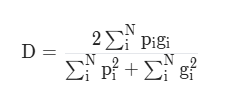

* Cross-entropy loss와 Dice loss를 같이 사용해 meanIoU를 더 올리도록 학습

In [47]:
# Image Segmentation Task에서 정답을 더 잘 찾아내기위해 새로운 Loss를 추가
def dice_coeff(y_true, y_pred):
    smooth = 1e-10
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(tf.square(y_true_f)) + \
                                            tf.reduce_sum(tf.square(y_pred_f)) + smooth)

    return score

In [48]:
# Dice Loss가 최대화되는 방향으로 구해지도록, 아래와 같이 사용
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [50]:
# 새로운 Loss function을 사용하기위해서 기존에 사용하였던 Binary crossentropy loss와 새로 구현한 Dice loss를 더하는 방식으로 구성
def bce_dice_loss(y_true, y_pred):
    loss = tf.reduce_mean(losses.binary_crossentropy(y_true, y_pred)) + dice_loss(y_true, y_pred)
    return loss

In [51]:
optimizer = tf.keras.optimizers.Adam() # 기본 Learning rate 사용

#### 모델선택

In [52]:
# 위에서 구성한 두가지 모델 중에서 하나를 선택해 주세요. 
# 여기서 선택을 바꾸어 다른 모델의 학습도 진행해 볼 수 있습니다. 

#print('select the Encoder-Decoder model')
#model = ed_model
#checkpoint_dir =os.path.join(DATASET_PATH,'train_ckpt/ed_model')

print('select the U-Net model')
model = unet_model
checkpoint_dir = os.path.join(DATASET_PATH,'train_ckpt/unet_model') #우리가 학습시키는 모델명

select the U-Net model


#### 컴파일(Compile)

In [54]:
#U-Net model로 컴파일과정
model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])
predictions = model(tf.random.normal([batch_size, image_size, image_size, 3]))
print(predictions.shape)

(8, 256, 256, 1)


In [55]:
#모델요약 확인 (U-Net model)
model.summary()

Model: "u_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_block (EncoderBlock) multiple                  76416     
_________________________________________________________________
encoder_block_1 (EncoderBloc multiple                  444288    
_________________________________________________________________
encoder_block_2 (EncoderBloc multiple                  1773312   
_________________________________________________________________
encoder_block_3 (EncoderBloc multiple                  7085568   
_________________________________________________________________
conv_block_4 (ConvBlock)     multiple                  28326912  
_________________________________________________________________
decoder_block (DecoderBlock) multiple                  18882048  
_________________________________________________________________
decoder_block_1 (DecoderBloc multiple                  354278

#### 콜백(Callbacks)

* Callback 함수들을 이용하여, 학습 중간에 원하는 동작을 할 수 있도록 한다.
  - ModelCheckpoint callback 함수는 모델 학습간 특정 feature를 모니터링하다 기준점을 넘으면 모델 파라미터를 저장하는 역할
  - LearningRateScheduler callback 함수는 학습을 진행하며, 주어진 인자의 값을 이용해 Learning rate를 조절해주는 함수
  - cos_decay는 cos 함수의 모양으로 Learning rate를 조절해 주는 learning rate decay 구현

In [58]:
if not os.path.isdir(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# 모델 학습간 특정 feature를 모니터링하다 기준점을 넘으면 모델 파라미터를 저장
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=0)

In [59]:
# cos 함수의 모양으로 Learning rate를 조절
cos_decay = tf.keras.experimental.CosineDecay(1e-3, 
                                              max_epochs)

lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1)

#### 모델 학습 (Train your model)

* 모델 학습 이전에, 모델에서 예측한 이미지를 출력할 수 있는 함수를 미리 작성해 모델 성능 테스트에 사용

In [60]:
# 인쇄 기능 정의
def print_images():
    for test_images, test_labels in test_dataset.take(1): #테스트데이타셋
        predictions = model(test_images, training=False) #테스트데이타셋-이미지학습데이타 (성능테스트)

        plt.figure(figsize=(10, 20))
        plt.subplot(1, 3, 1)
        plt.imshow(test_images[0,: , :, :])
        plt.title("Input image")

        plt.subplot(1, 3, 2)
        plt.imshow(test_labels[0, :, :, 0])
        plt.title("Actual Mask")

        plt.subplot(1, 3, 3)
        plt.imshow(predictions[0, :, :, 0])
        plt.title("Predicted Mask")
        plt.show()

#### 훈련 - model.fit() 함수 이용

* Train dataset과 Test dataset등을 이용해 학습을 진행
* 학습 데이터의 갯수가 부족하기때문에 Test dataset을 Validation dataset으로 사용

In [61]:
#  model를 학습하는 코드, 10 Epoch만 학습을 진행후 미리 학습된 모델을 불러올 예정
history = model.fit(train_dataset,
                    epochs=max_epochs,    # 10
                    steps_per_epoch=num_train_examples//batch_size,
                    validation_data=test_dataset,
                    validation_steps=num_test_examples//batch_size,
                    callbacks=[cp_callback, lr_callback]
                    )

Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
30/30 [==============================] - 40s 907ms/step - loss: 1.0559 - dice_loss: 0.7302 - val_loss: 1348.9187 - val_dice_loss: 0.8979
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.00097552827, shape=(), dtype=float32).
30/30 [==============================] - 27s 858ms/step - loss: 0.8962 - dice_loss: 0.6848 - val_loss: 23.8592 - val_dice_loss: 1.0000
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009045085, shape=(), dtype=float32).
30/30 [==============================] - 28s 878ms/step - loss: 0.8770 - dice_loss: 0.6700 - val_loss: 50.3716 - val_dice_loss: 1.0000
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.00079389266, shape=(), dtype=float32).
30/30 [==============================] - 28s 872ms/step - loss: 0.8703 - dice_loss: 0.6707 - val_loss: 23.2913

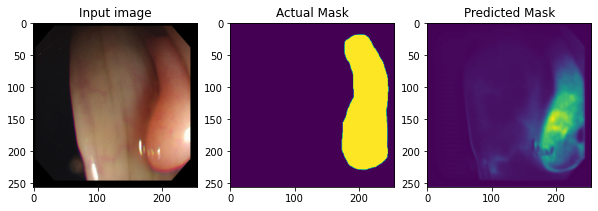

In [64]:
# 학습 후 샘플 이미지 출력
print_images()

#### 손실처리

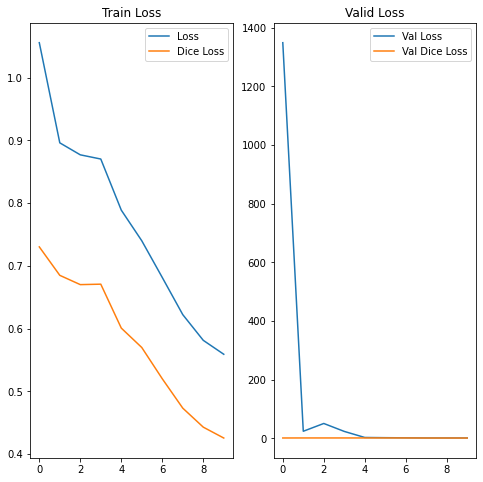

In [65]:
# 저장된 학습 진행과정(history)을 시각화
dice_loss = history.history['dice_loss']
loss = history.history['loss']
val_dice_loss = history.history['val_dice_loss']
val_loss = history.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Loss')
plt.plot(epochs_range, dice_loss, label='Dice Loss')
plt.legend(loc='upper right')
plt.title('Train Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')
plt.legend(loc='upper right')
plt.title('Valid Loss')
plt.show()

#### 저장된 모델의 가중치를 불러오기 (Restore the latest checkpoint)

* 저장된 모델의 가중치를 불러오기
* ed_ckpt나 unet_ckpt에 담긴 것이 미리 학습시킨 모델임
* 직접 학습시킨 모델은 train_ckpt에 있음
* 원하는 모델을 불러와 사용하기

In [66]:
# 원하는 모델을 불러올 수 있도록 적절히 주석을 처리하세요
# checkpoint_dir = os.path.join(DATASET_PATH, 'ed_ckpt/ed_model')
#checkpoint_dir = os.path.join(DATASET_PATH, 'unet_ckpt/unet_model')
checkpoint_dir = os.path.join(DATASET_PATH, 'train_ckpt/unet_model')

# restoring the latest checkpoint in checkpoint_dir
model.load_weights(checkpoint_dir)

#### 테스트 데이터 세트 성능평가

* 가중치를 이용해서 모델을 평가
  - 정량적으로 평가 : meanIoU(meanIoU란 각 이미지의 IoU 값을 평균 낸 값)를 metric으로 평가
  - 정성적으로 평가 : 실제 생성된 segmentation 이미지를 분석
  
* IoU는 segmentation 모델을 정량적으로 평가하는데 좋은 metric 된다

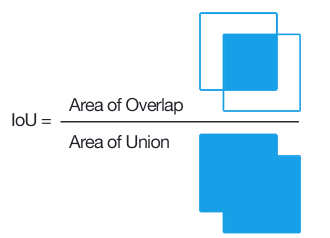

In [67]:
#metric으로 정량적으로 평가
def mean_iou(y_true, y_pred, num_classes=2):
    # Flatten  
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    y_true_f = tf.cast(tf.round(y_true_f), dtype=tf.int32).numpy()
    y_pred_f = tf.cast(tf.round(y_pred_f), dtype=tf.int32).numpy()

    # calculate confusion matrix
    labels = list(range(num_classes))
    current = confusion_matrix(y_true_f, y_pred_f, labels=labels)

    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection

    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

* 테스트 데이터셋을 불러와서 meanIoU 값을 구하기
* 우리가 훈련시킨 모델에 대한 정량적 성능 metric이 된다

In [68]:
# 테스트 데이터셋을 불러와서 meanIoU 값을 구하기

mean = []

for images, labels in test_dataset:
    predictions = model(images, training=False)
    m = mean_iou(labels, predictions)
    mean.append(m)

mean = np.array(mean)
mean = np.mean(mean)
print("mean_iou: {}".format(mean))

mean_iou: 0.4761745662753722


In [69]:
# Test Dataset 내에 데이터들을 얼만큼 잘 맞추었는지 직접 확인

## 출력기능정의
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        for i in range(batch_size):
            plt.figure(figsize=(10, 20))
            plt.subplot(1, 3, 1)
            plt.imshow(test_images[i,: , :, :])
            plt.title("Input image")

            plt.subplot(1, 3, 2)
            plt.imshow(test_labels[i, :, :, 0])
            plt.title("Actual Mask")

            plt.subplot(1, 3, 3)
            plt.imshow(predictions[i, :, :, 0])
            plt.title("Predicted Mask")
            plt.show()

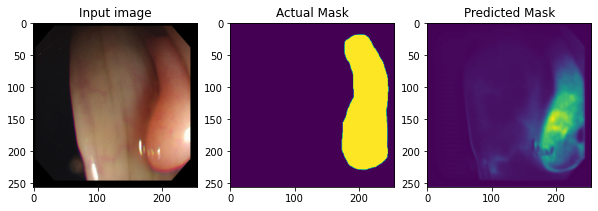

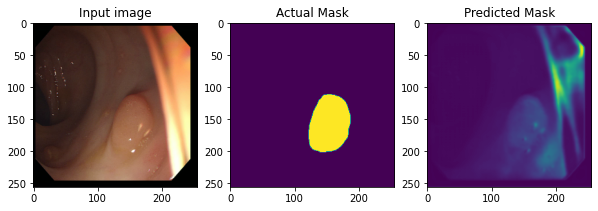

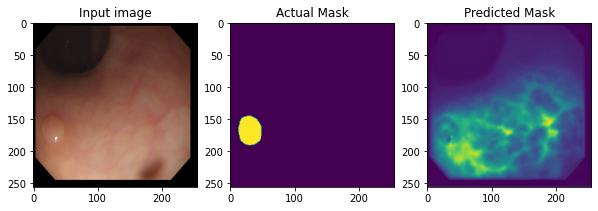

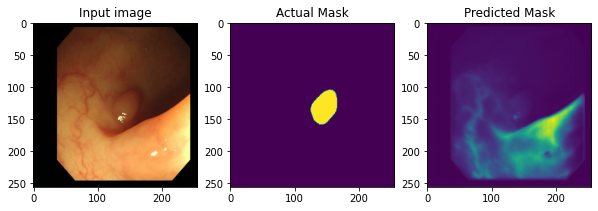

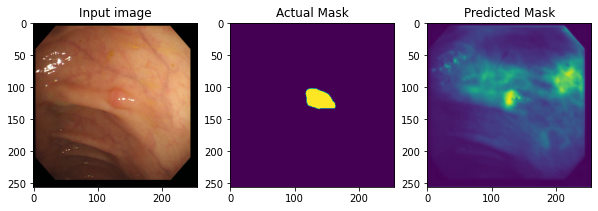

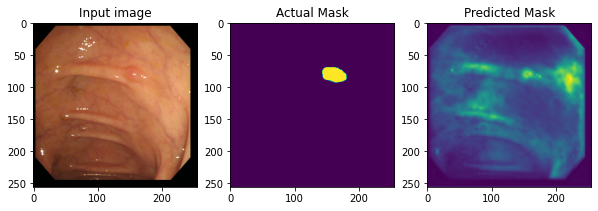

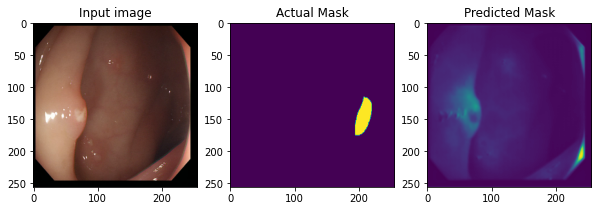

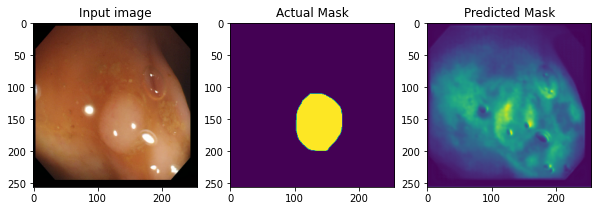

In [70]:
# 학습 후 테스트데이타셋의 샘플 이미지 출력
print_images()